In [12]:
from cognipy.ontology import Ontology
from cognipy.ontology import CQL
from cognipy.ontology import ABoxBatch
from cognipy.ontology import encode_string_for_graph_label
from cognipy.edit import CnlEditBox
from cognipy.edit import CnlQueryForConcept

import random
import textwrap
import numpy as np

def graph_attribute_formatter(val):
    if isinstance(val,list) or isinstance(val,set):
        return " | ".join(list(map(lambda i:encode_string_for_graph_label(graph_attribute_formatter(i)),val)))
    elif isinstance(val,dict):
        return " | ".join(list(map(lambda i:i[0]+" : "+encode_string_for_graph_label(graph_attribute_formatter(i[1])),val.items())))
    else:
        return encode_string_for_graph_label(textwrap.fill(str(val),40))

def string_evaluator(e):
    return eval(str(e).encode('utf-8').decode('unicode_escape'),globals(),locals())    

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity

def Qstr(a):
    return "Q('"+str(a)+"')"
Q.__repr__=Qstr    

import ipywidgets as widgets

In [13]:
ed=CnlEditBox('meta.encnl')
ed

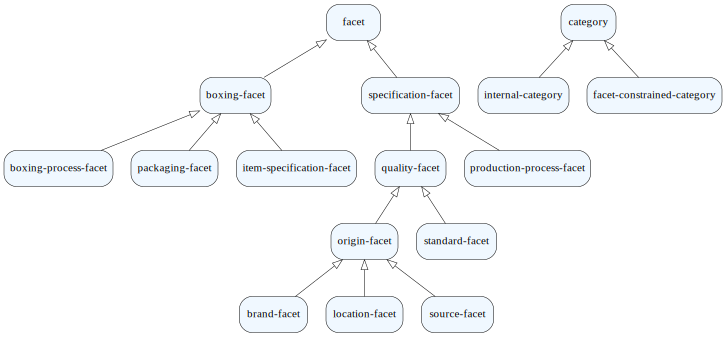

In [14]:
Ontology("cnl/file",'meta.encnl').draw_graph()

In [15]:
ed=CnlEditBox('meat-beef.encnl')
ed

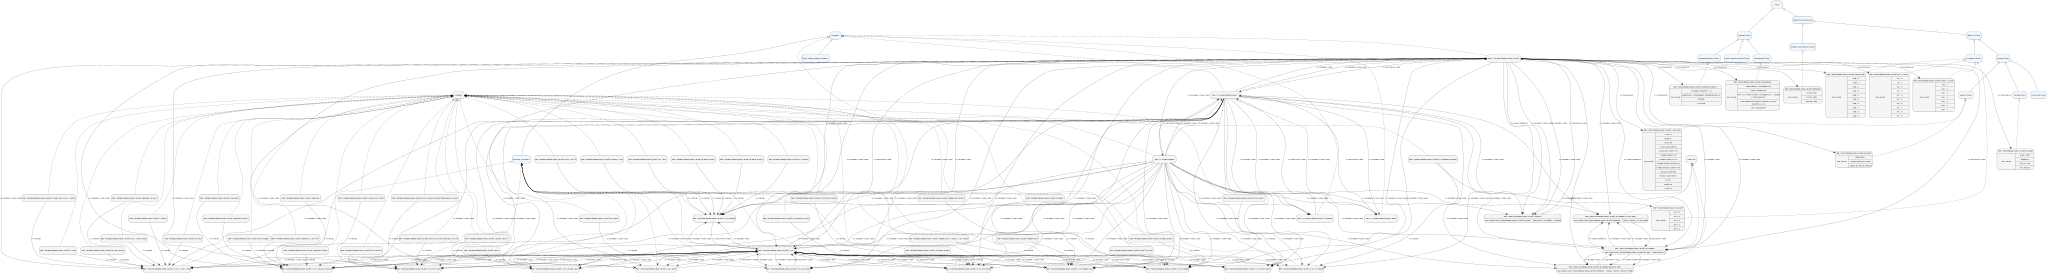

In [16]:
onto = Ontology("cnl/file",'meat-beef.encnl', evaluator = string_evaluator, graph_attribute_formatter = graph_attribute_formatter)
onto.draw_graph(include={"is-broader-trans-than"} )

In [17]:
def generateMoreFromExisting(onto):
    with open('meat-beef-cat.encnl','wt') as file:
        for iName in onto.select_instances_of("a product")["Instance"]:
            iCatName=iName.replace('"Product$','"Category$')
            iCatName=iCatName[:iCatName.rfind('/')]+'"'
            file.writelines(iName+" is-inside "+iCatName+".\n")
        
        for index,row in onto.select_instances_of("a facet").iterrows():
            iFacet = row["Instance"]
            values= row["has-value"]
            for val in values:
                fval=iFacet[:-1]+"/"+val+'"'
                file.writelines(fval+" is a facet-option.\n")
                file.writelines(fval+' is-an-option-for '+iFacet+'.\n')
                
        file.writelines("""
References: 
[] ('./meat-beef.encnl').""")
        

In [18]:
generateMoreFromExisting(onto)
ed2=CnlEditBox('meat-beef-cat.encnl')
ed2

In [19]:
onto = Ontology("cnl/file",'meat-beef-cat.encnl', evaluator = string_evaluator, graph_attribute_formatter = graph_attribute_formatter)

In [20]:
import pandas as pd
import fuzzy

In [21]:
dmeta = fuzzy.DMetaphone()

def makeTags(wrd):
    wrdl=wrd.lower()
    tgs=[(0,wrdl)]
    if len(wrdl)>4:
        tags = dmeta(wrdl)
        for t in tags:
            if not t is None:
                tgs.append((1,t))
    return tgs
    
def tagifySerie(ser):
    data = []
    for iName in ser:
        name=iName[iName.find('$')+1:-1]
        name_tags=[]
        for x in name.split('/'):
            for y in x.split('='):
                for yy in y.split(','):
                    for z in yy.split(' '):
                        name_tags.extend(makeTags(z))
                        
        for t in set(name_tags):
            data.append([t,iName])
        
    return pd.DataFrame(data,columns=['tag','id'])

def tagsForString(searchStr,exclude):
    dmeta = fuzzy.DMetaphone()
    toret= [x for y in [makeTags(w) for w in searchStr.split(' ')] for x in y if (not x is None) and (not x in exclude)]
    return set(toret)

In [22]:
def tagifySerie2(ser):
    data = []
    for iName in ser:
        name=iName[iName.find('$')+1:-1]
        name_tags=[]
        for x in name.split('/'):
            for y in x.split('='):
                for yy in y.split(','):
                    spl=yy.split(' ')
                    name_tags.extend([(s,0) for s in spl])
                    if len(spl)==2:
                        name_tags.append((tuple(spl),1))
                        
        more = [(dmeta(t[0]),2) if isinstance(t[0],str) else ((dmeta(t[0][0]),dmeta(t[0][1])),3) for t in name_tags]
        for t in set(name_tags.extend(more)):
            data.append([t,iName])
        
    return pd.DataFrame(data,columns=['tag','id'])


In [23]:
def buildBroaderThanThanRelation(catspd,rel, columns=["id","subid"]):
    data = []
    for index, row in catspd.iterrows():
        iName = row["Instance"]
        iBroaders = row[rel]
        if not iBroaders is None:
            if isinstance(iBroaders, str): 
                data.append([iName,iBroaders])
            else:
                for iBroader in iBroaders:
                    data.append([iName,iBroader])
    return pd.DataFrame(data, columns=columns).drop_duplicates()

In [24]:
def buildInsideCategoryRelation(prodspd,rel, columns=["id","mainid"]):
    data = []
    for index, row in prodspd.iterrows():
        iName = row["Instance"]
        iCat = row[rel]
        if not iCat is None:
            data.append([iName,iCat])
    return pd.DataFrame(data, columns=columns).drop_duplicates()

In [26]:
catspd=onto.sparql_query(CQL('select ?x ?y ?z {?x rdf:type <category>. optional{?y rdf:type <category>. ?x <is-broader-trans-than> ?y}. optional{?z rdf:type <facet>. ?x <is-faceted-by> ?z}}'),column_names=['Instance','is-broader-trans-than','is-faceted-by'])
categoryHierarchy=onto.sparql_query(CQL('select ?x ?y {?x rdf:type <category>. ?y rdf:type <category>. ?x <is-broader-than> ?y}'),column_names=['super','sub'])
prodspd=onto.sparql_query(CQL('select ?x ?y ?z {?x rdf:type <product>. optional{?y rdf:type <category>. ?x <is-inside> ?y}. optional{?z rdf:type <facet>. ?x <is-faceted-by> ?z}}'),column_names=['Instance','is-inside','is-faceted-by'])
facvalpd=onto.sparql_query(CQL('select ?x ?y {?x rdf:type <facet-option>. ?y rdf:type <facet>. ?x <is-an-option-for> ?y}'),column_names=['Instance','is-an-option-for'])

catetoryTagIndex=tagifySerie(catspd['Instance'].drop_duplicates())
categoryBroaderThanThanRelation=buildBroaderThanThanRelation(catspd,'is-broader-trans-than', columns=["broaderid","catid"])
productTagIndex =tagifySerie(prodspd['Instance'].drop_duplicates())
productInsideCategoryRelation=buildInsideCategoryRelation(prodspd,'is-inside', columns=["id","mainid"])
valuesInsideFacetRelation=buildInsideCategoryRelation(facvalpd,'is-an-option-for', columns=["id","mainid"])
facetValTagIndex =tagifySerie(facvalpd['Instance'].drop_duplicates())
categoryFacetRelation=buildBroaderThanThanRelation(catspd,'is-faceted-by', columns=["catid","facetid"])
productFacetRelation=buildBroaderThanThanRelation(prodspd,'is-faceted-by', columns=["prodid","facetid"])
database={'catetoryTagIndex':catetoryTagIndex, 
          'categoryBroaderThanThanRelation':categoryBroaderThanThanRelation,
          'productTagIndex':productTagIndex,
          'productInsideCategoryRelation':productInsideCategoryRelation,
          'valuesInsideFacetRelation':valuesInsideFacetRelation,
          'facetValTagIndex':facetValTagIndex,
          'categoryFacetRelation':categoryFacetRelation,
          'productFacetRelation':productFacetRelation,
          'categoryHierarchy':categoryHierarchy
         }

In [27]:
def lookupForString(tagIndex,searchStr,exclude={},nmax=1):
    pticnt=tagIndex.groupby(by='tag').count()
    resc=tagIndex[(tagIndex['tag'].isin(tagsForString(searchStr,exclude)))][['tag','id']]
    apl=resc.apply(lambda row: 1.0/pticnt[pticnt.index==row['tag']].sum(),axis=1)['id']
    resc['frac']=apl
    pdCounts=resc.groupby(by='id').sum()
    if len(pdCounts)==0:
        return []
    max = list(pdCounts.nlargest(nmax,'frac')['frac'])
    winCats=pdCounts[pdCounts['frac'].isin(max)]
    wss=[(w.name,w['frac']) for i,w in winCats.iterrows()]
    wss.sort(key=lambda x: x[1], reverse=True)
    return [x for (x,y) in wss]

In [28]:
searchStr='meat cow waygu sex cl 80'

selectedCatLst=lookupForString(database['catetoryTagIndex'],searchStr)
selectedCat = set(selectedCatLst)

if len(selectedCat)>0:
    serie = database['productTagIndex']\
                    .join(database['productInsideCategoryRelation'][\
                            database['productInsideCategoryRelation']['mainid'].apply(lambda mainid:(mainid in selectedCat))]\
                    .set_index('id'),on=['id'],how='inner')
else:
    serie = database['productTagIndex']

selectedProd=lookupForString(serie,searchStr,exclude=set(tagifySerie([selectedCatLst[0]])['tag']) if len(selectedCat)>0 else {})
if len(selectedProd)>0:
    selectedCatLst=list(database['productInsideCategoryRelation'][database['productInsideCategoryRelation']['id'].isin(selectedProd)]['mainid'].drop_duplicates())
    selectedCat=set(selectedCatLst)
else:
    selectedProdLst=list(database['productInsideCategoryRelation'][database['productInsideCategoryRelation']['mainid'].isin(selectedCat)]['id'].drop_duplicates())
    selectedProd=set(selectedProdLst)
    
if len(selectedProd)>0:
    facetProdSerie = database['productFacetRelation'][database['productFacetRelation']['prodid'].isin(selectedProd)]
    facetProdSerie = facetProdSerie.join(database['valuesInsideFacetRelation'].set_index('mainid'),on=['facetid'],how='inner')
    facetProdSerie = database['facetValTagIndex'].join(facetProdSerie.set_index('id'),on=['id'],how='inner')
else:
    facetProdSerie = None

if len(selectedCat)>0:
    broaderThanSelectedCat = set(database['categoryBroaderThanThanRelation'][database['categoryBroaderThanThanRelation']['catid'].isin(selectedCat)]['broaderid'])
    broaderOrEqualThanSelectedCat=selectedCat.union(broaderThanSelectedCat)
    facetSerie = database['categoryFacetRelation'][database['categoryFacetRelation']['catid'].isin(broaderOrEqualThanSelectedCat)]
    facetSerie = facetSerie.join(database['valuesInsideFacetRelation'].set_index('mainid'),on=['facetid'],how='inner')
    facetSerie = database['facetValTagIndex'].join(facetSerie.set_index('id'),on=['id'],how='inner')
else:
    facetSerie = database['facetValTagIndex']
    
selectedFacetVal=lookupForString(facetSerie,searchStr,exclude=set(tagifySerie([selectedCatLst[0]])['tag']) if len(selectedCat)>0 else {},nmax=100000)
if not facetProdSerie is None:
    selectedFacetProdVal=lookupForString(facetProdSerie,searchStr,exclude=set(tagifySerie([selectedCatLst[0]])['tag']) if len(selectedCat)>0 else {},nmax=100000)
else:
    selectedFacetProdVal=[]

selectedFacetLst=[]
if len(selectedFacetVal)>0:
    selectedFacetLst=list(database['valuesInsideFacetRelation'][database['valuesInsideFacetRelation']['id'].isin(selectedFacetVal)]['mainid'].drop_duplicates())
    if len(selectedProd)>0:
        selectedCatLst=list(database['productInsideCategoryRelation'][database['productInsideCategoryRelation']['id'].isin(selectedProd)]['mainid'].drop_duplicates())
        selectedCat=set(selectedCatLst)

selectedFacetProdLst=[]
if len(selectedFacetProdVal)>0:
    selectedFacetProdLst=list(database['valuesInsideFacetRelation'][database['valuesInsideFacetRelation']['id'].isin(selectedFacetProdVal)]['mainid'].drop_duplicates())
    selectedProdLst=database['productFacetRelation'][database['productFacetRelation']['facetid'].isin(selectedFacetProdLst)]['prodid']
    selectedProd = set(selectedProdLst)   
    if len(selectedProd)>0:
        selectedCatLst=list(database['productInsideCategoryRelation'][database['productInsideCategoryRelation']['id'].isin(selectedProd)]['mainid'].drop_duplicates())
        selectedCat=set(selectedCatLst)

possibleFacets = {}
if len(selectedCat)>0:
    broaderThanSelectedCat = set(database['categoryBroaderThanThanRelation'][database['categoryBroaderThanThanRelation']['catid'].isin(selectedCat)]['broaderid'])
    broaderOrEqualThanSelectedCat=selectedCat.union(broaderThanSelectedCat)
    possibleFacets = set(database['categoryFacetRelation'][database['categoryFacetRelation']['catid'].isin(broaderOrEqualThanSelectedCat)]['facetid'])

if len(selectedProd)>0:
    facetProdSerie = database['productFacetRelation'][database['productFacetRelation']['prodid'].isin(selectedProd)]['facetid']
    possibleFacets=possibleFacets.union(facetProdSerie)
    
facets=[]
for facet in possibleFacets:
    fctvals=set(database['valuesInsideFacetRelation'][database['valuesInsideFacetRelation']['mainid']==facet]['id'])
    tags = database['facetValTagIndex'][database['facetValTagIndex']['id'].isin(fctvals)]
    selectedFacetVal=lookupForString(tags,searchStr,exclude=set(tagifySerie([selectedCatLst[0]])['tag']) if len(selectedCat)>0 else {},nmax=1)
    facets.append({'facet':facet, 'value':selectedFacetVal[0] if len(selectedFacetVal)>0 else None})
    
ret={'category':selectedCatLst, 'product':selectedProd, 'facets':facets}
ret

{'category': ['The-"Internal$Food/Meat/Beef/Cut/Grinding"',
  'The-"Category$Food/Meat/Beef"'],
 'product': {'The-"Product$Food/Meat/Beef/Grinding=Minced"'},
 'facets': [{'facet': 'The-"Facet$Food/Meat/Beef/Age Sex"',
   'value': 'The-"Facet$Food/Meat/Beef/Age Sex/Cow=C"'},
  {'facet': 'The-"Facet$Food/Meat/Minced"',
   'value': 'The-"Facet$Food/Meat/Minced/80 CL"'},
  {'facet': 'The-"Facet$Food/Meat/Beef/Meat Color"', 'value': None},
  {'facet': 'The-"Facet$Food/Meat/Beef/Boxing Process"', 'value': None},
  {'facet': 'The-"Facet$Food/Meat/Beef/Packaging"', 'value': None},
  {'facet': 'The-"Facet$Food/Meat/Beef/Feeding"', 'value': None},
  {'facet': 'The-"Facet$Food/Meat/Beef/Breed"',
   'value': 'The-"Facet$Food/Meat/Beef/Breed/Wagyu/Tajima,Kobe"'},
  {'facet': 'The-"Facet$Food/Meat/Beef/Fat Color"', 'value': None},
  {'facet': 'The-"Facet$Food/Meat/Beef/Brand"', 'value': None},
  {'facet': 'The-"Facet$Food/Meat/Beef/Marbling"', 'value': None}]}

In [29]:
def smartLookup(database,searchStr):
    selectedCatLst=lookupForString(database['catetoryTagIndex'],searchStr)
    selectedCat = set(selectedCatLst)

    if len(selectedCat)>0:
        serie = database['productTagIndex']\
                        .join(database['productInsideCategoryRelation'][\
                                database['productInsideCategoryRelation']['mainid'].apply(lambda mainid:(mainid in selectedCat))]\
                        .set_index('id'),on=['id'],how='inner')
    else:
        serie = database['productTagIndex']

    selectedProd=lookupForString(serie,searchStr,exclude=set(tagifySerie([selectedCatLst[0]])['tag']) if len(selectedCat)>0 else {})
    if len(selectedProd)>0:
        selectedCatLst=list(database['productInsideCategoryRelation'][database['productInsideCategoryRelation']['id'].isin(selectedProd)]['mainid'].drop_duplicates())
        selectedCat=set(selectedCatLst)
    else:
        selectedProdLst=list(database['productInsideCategoryRelation'][database['productInsideCategoryRelation']['mainid'].isin(selectedCat)]['id'].drop_duplicates())
        selectedProd=set(selectedProdLst)

    if len(selectedProd)>0:
        facetProdSerie = database['productFacetRelation'][database['productFacetRelation']['prodid'].isin(selectedProd)]
        facetProdSerie = facetProdSerie.join(database['valuesInsideFacetRelation'].set_index('mainid'),on=['facetid'],how='inner')
        facetProdSerie = database['facetValTagIndex'].join(facetProdSerie.set_index('id'),on=['id'],how='inner')
    else:
        facetProdSerie = None

    if len(selectedCat)>0:
        broaderThanSelectedCat = set(database['categoryBroaderThanThanRelation'][database['categoryBroaderThanThanRelation']['catid'].isin(selectedCat)]['broaderid'])
        broaderOrEqualThanSelectedCat=selectedCat.union(broaderThanSelectedCat)
        facetSerie = database['categoryFacetRelation'][database['categoryFacetRelation']['catid'].isin(broaderOrEqualThanSelectedCat)]
        facetSerie = facetSerie.join(database['valuesInsideFacetRelation'].set_index('mainid'),on=['facetid'],how='inner')
        facetSerie = database['facetValTagIndex'].join(facetSerie.set_index('id'),on=['id'],how='inner')
    else:
        facetSerie = database['facetValTagIndex']

    selectedFacetVal=lookupForString(facetSerie,searchStr,exclude=set(tagifySerie([selectedCatLst[0]])['tag']) if len(selectedCat)>0 else {},nmax=100000)
    if not facetProdSerie is None:
        selectedFacetProdVal=lookupForString(facetProdSerie,searchStr,exclude=set(tagifySerie([selectedCatLst[0]])['tag']) if len(selectedCat)>0 else {},nmax=100000)
    else:
        selectedFacetProdVal=[]

    selectedFacetLst=[]
    if len(selectedFacetVal)>0:
        selectedFacetLst=list(database['valuesInsideFacetRelation'][database['valuesInsideFacetRelation']['id'].isin(selectedFacetVal)]['mainid'].drop_duplicates())
        if len(selectedProd)>0:
            selectedCatLst=list(database['productInsideCategoryRelation'][database['productInsideCategoryRelation']['id'].isin(selectedProd)]['mainid'].drop_duplicates())
            selectedCat=set(selectedCatLst)

    selectedFacetProdLst=[]
    if len(selectedFacetProdVal)>0:
        selectedFacetProdLst=list(database['valuesInsideFacetRelation'][database['valuesInsideFacetRelation']['id'].isin(selectedFacetProdVal)]['mainid'].drop_duplicates())
        selectedProdLst=database['productFacetRelation'][database['productFacetRelation']['facetid'].isin(selectedFacetProdLst)]['prodid']
        selectedProd = set(selectedProdLst)   
        if len(selectedProd)>0:
            selectedCatLst=list(database['productInsideCategoryRelation'][database['productInsideCategoryRelation']['id'].isin(selectedProd)]['mainid'].drop_duplicates())
            selectedCat=set(selectedCatLst)

    possibleFacets = {}
    if len(selectedCat)>0:
        broaderThanSelectedCat = set(database['categoryBroaderThanThanRelation'][database['categoryBroaderThanThanRelation']['catid'].isin(selectedCat)]['broaderid'])
        broaderOrEqualThanSelectedCat=selectedCat.union(broaderThanSelectedCat)
        possibleFacets = set(database['categoryFacetRelation'][database['categoryFacetRelation']['catid'].isin(broaderOrEqualThanSelectedCat)]['facetid'])

    if len(selectedProd)>0:
        facetProdSerie = database['productFacetRelation'][database['productFacetRelation']['prodid'].isin(selectedProd)]['facetid']
        possibleFacets=possibleFacets.union(facetProdSerie)

    facets=[]
    for facet in possibleFacets:
        fctvals=set(database['valuesInsideFacetRelation'][database['valuesInsideFacetRelation']['mainid']==facet]['id'])
        tags = database['facetValTagIndex'][database['facetValTagIndex']['id'].isin(fctvals)]
        selectedFacetVal=lookupForString(tags,searchStr,exclude=set(tagifySerie([selectedCatLst[0]])['tag']) if len(selectedCat)>0 else {},nmax=1)
        facets.append({'facet':[facet], 'value':[selectedFacetVal[0] if len(selectedFacetVal)>0 else None]})

    return {'category':selectedCatLst, 'product':selectedProd, 'facets':facets}

In [30]:
import ipywidgets as widgets
from IPython.display import display,HTML,clear_output
from flask_table import Table, Col, NestedTableCol

In [31]:
def getCategoryUI(database, category,clb):
    c=[c for c in category if c.startswith('The-"Category$')]
    if(len(c)>0):
        mainCat = c[0]
    else:
        mainCat = 'The-"Category$Food"'
    nameMainCat=mainCat[mainCat.find('$')+1:-1].split('/')
    curName=''
    menu=[]
    for n in nameMainCat:
        curName=curName+'/'+n if curName!='' else n
        curNameIns = 'The-"Category$'+curName+'"'
        subIns = list(database['categoryHierarchy'][(database['categoryHierarchy']['super']==curNameIns) & (database['categoryHierarchy']['sub'].apply(lambda x: x.startswith('The-"Category$')))]['sub'])
        if len(subIns)==0:
            break
        subNames = [c[c.find('$')+1:-1].split('/')[-1] for c in subIns ]
        tobbut= widgets.ToggleButtons(
            options=subNames,
            description=curName,
            disabled=False,
            button_style='info', # 'success', 'info', 'warning', 'danger' or ''
            tooltips=subIns,
            value = None
        #     icons=['check'] * 3
        )

        menu.append(tobbut)

    def on_value_change(b):
        clb(b.owner.options[b.owner.index])

    for i in range(len(menu)):
        if i+1<len(nameMainCat):
            menu[i].value=nameMainCat[i+1]
        menu[i].observe(on_value_change, names='value')      

    return widgets.VBox(menu)

In [32]:
def getProductUI(database, product,clb):
    opc=[c[c.find('$')+1:-1].split('/')[-1] for c in product]
    opc.sort()
    tobbut= widgets.ToggleButtons(
        options=opc,
        description='Product',
        disabled=False,
        button_style='success', # 'success', 'info', 'warning', 'danger' or ''
        tooltips=list(product),
        value = None if len(product)>1 or len(product)==0 else opc[0]
    #     icons=['check'] * 3
    )
    def on_value_change(b):
        clb(b.owner.options[b.owner.index])

    tobbut.observe(on_value_change, names='value')      
        
    return tobbut

In [33]:
def getFacetsUI(database, facets,clb):
    menu=[]

    for facetValDict in facets:
        facetIns = facetValDict['facet'][0]
        facetVal = facetValDict['value'][0] if not facetValDict['value'] is None else None
        
        pp=database['valuesInsideFacetRelation'][database['valuesInsideFacetRelation']['mainid']==facetIns]
        facetVals = list(pp['id'])
        facetVals.sort()
        facetNames = [c[c.find('$')+1:-1].split('/')[-1] for c in facetVals]
        tobbut= widgets.ToggleButtons(
            options=facetNames,
            description=facetIns[facetIns.find('$')+1:-1].split('/')[-1],
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltips=list(facetVals),
            value = facetVal[facetVal.find('$')+1:-1].split('/')[-1] if not facetVal is None else None
        #     icons=['check'] * 3
        )
        menu.append(tobbut)
        def on_value_change(b):
            clb(b.owner.options[b.owner.index])

        tobbut.observe(on_value_change, names='value')      
        
    return widgets.VBox(menu)

In [34]:
InitValue = 'meat cow waygu'

import collections

edit_widget=widgets.Text(
                value = InitValue,
                placeholder='Type something',
                disabled=False,
                layout=widgets.Layout(width='90%'),
                style={'description_width': 'initial'}
            )


outoput_widget=widgets.Output()
outoput_prods_widget=widgets.Output()

def buildTextFromUI():
    ui = outoput_widget.ui
    catui = ui.children[0]
    txt = ' '.join([tb.value for tb in catui.children if not tb.value is None])
    
    if len(ui.children)>1:
        produi,facetui = ui.children[1],ui.children[2]
        if not produi.value is None:
            txt = txt+ ' '+produi.value
    
        txt = txt+ ' '+' '.join([tb.value for tb in facetui.children if not tb.value is None])
    
    return txt

def onCategoryClicked(category):
    edit_widget.value=buildTextFromUI()

def onProductClicked(product):
    edit_widget.value=buildTextFromUI()

def onFacetClicked(facet):
    edit_widget.value=buildTextFromUI()

def reload(searchStr):
    with outoput_widget:
        clear_output()
        look=smartLookup(database,searchStr)

        catui=getCategoryUI(database,look['category'],onCategoryClicked)

        if len(look['product'])>0:
            produi=getProductUI(database,look['product'],onProductClicked)

            facetui=getFacetsUI(database,look['facets'],onFacetClicked)

            ui = widgets.VBox([catui,produi,facetui])
        else:
            ui = widgets.VBox([catui])
        
        outoput_widget.ui = ui
        display(ui) 


def onChange(change):
    searchStr=change.new
    reload(searchStr)

        
onChange(collections.namedtuple('x','new')(new=edit_widget.value))
edit_widget.observe(onChange, names=['cursor','value'])
widgets.HBox([widgets.VBox([edit_widget,outoput_widget],layout=widgets.Layout(width='50%')),outoput_prods_widget])